### Loading data

In [49]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import torch as T
device = "cpu"

demand_data = pd.read_csv("../simulated_data/simulated_demand.csv")
demand_data.starttime = pd.to_datetime(demand_data.starttime)
demand_data=demand_data.groupby(["location", "car_type"]).resample("5min", on="starttime")["id"].count().reset_index(name="count")
demand_data.head()


,location,car_type,starttime,count
0,loc_0,comfort,2022-11-07 16:40:00,1
1,loc_0,comfort,2022-11-07 16:45:00,1
2,loc_0,comfort,2022-11-07 16:50:00,3
3,loc_0,comfort,2022-11-07 16:55:00,5
4,loc_0,comfort,2022-11-07 17:00:00,2


### Pytorch auto-encoder

In [50]:
import numpy as np
TIME_STEPS = 20

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []  
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)
mean =demand_data['count'].mean()
std = demand_data['count'].std()
demand_data['count'] = (demand_data['count']- mean)/std
demand_data_encoded = pd.get_dummies(demand_data, columns=['location', 'car_type'])
demand_data_encoded =demand_data_encoded.drop("starttime", axis=1)

x_train = create_sequences(demand_data_encoded.values)
# x_train= np.float32(x_train)
x_train = np.expand_dims(x_train, 1)
x_train = T.tensor(np.float32(x_train), dtype=T.float32).to(device) 

print("Training input shape: ", x_train.shape)


Training input shape:  torch.Size([2682, 1, 20, 25])


In [12]:
import torch as T
class Autoencoder(T.nn.Module):  # 65-32-8-32-65
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.fc1 = T.nn.Conv2d(1,32,7)
    self.fc2 = T.nn.Conv2d(32,16,7)
    self.fc3 = T.nn.ConvTranspose2d(16,32,7)
    self.fc4 = T.nn.ConvTranspose2d(32,1,7)
    # self.fc5 = T.nn.ConvTranspose2d(32,1,7)

  def encode(self, x):  # 65-32-8
    z = T.tanh(self.fc1(x))
    z = T.tanh(self.fc2(z))  # latent in [-1,+1]
    return z  

  def decode(self, x):  # 8-32-65
    z = T.tanh(self.fc3(x))
    z = T.sigmoid(self.fc4(z))
    # z = T.sigmoid(self.fc5(z))  # [0.0, 1.0]
    return z
    
  def forward(self, x):
    z = self.encode(x) 
    z = self.decode(z) 
    return z  # in [0.0, 1.0]

In [60]:
import os


def train(ae, ds, bs, me, le, lr):
  # autoencoder, dataset, batch_size, max_epochs,
  # log_every, learn_rate
  # assumes ae.train() has been set
  data_ldr = T.utils.data.DataLoader(ds, batch_size=bs,
    shuffle=True)
  loss_func = T.nn.MSELoss()
  opt = T.optim.SGD(ae.parameters(), lr=lr)
  print("\nStarting training")
  for epoch in range(0, me):
    epoch_loss = 0.0
    for (batch_idx, batch) in enumerate(data_ldr):
      X = batch  # inputs
      Y = batch  # targets (same as inputs)

      opt.zero_grad()                # prepare gradients
      oupt = ae(X)                   # compute output/target
      # print("oupt shape", oupt.shape)
      loss_val = loss_func(oupt, Y)  # a tensor
      epoch_loss += loss_val.item()  # accumulate for display
      loss_val.backward()            # compute gradients
      opt.step()                     # update weights

    if epoch % le == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
    os.makedirs("models", exist_ok=True)
    T.save(ae.state_dict(),"models/autoencoder.json" )
  print("Done ")
  

def make_err_list(model, ds):
  # assumes model.eval()
  result_lst = []
  n_features = len(ds[0])  # 65
  for i in range(len(ds)):
    X = ds[i]
    with T.no_grad():
      Y = model(X)  # should be same as X
    err = T.sum((X-Y)*(X-Y)).item()  # SSE all features
    err = err / n_features           # sort of norm'ed SSE 
    result_lst.append( (i,err) )     # idx of data item, err
  return result_lst 

# -----------------------------------------------------------

def main():
  # 0. get started
  print("\nBegin autoencoder anomaly demo ")
  T.manual_seed(1)
  np.random.seed(1)


  # 2. create autoencoder net
  print("\nCreating a 65-32-8-32-65 autoencoder ")
  autoenc = Autoencoder().to(device)
  autoenc.train()   # set mode

  # 3. train autoencoder model
  bat_size = 10
  max_epochs = 100
  log_interval = 10
  lrn_rate = 0.005

  print("\nbat_size = %3d " % bat_size)
  print("max epochs = " + str(max_epochs))
  print("loss = MSELoss")
  print("optimizer = SGD")
  print("lrn_rate = %0.3f " % lrn_rate)
  train(autoenc, x_train, bat_size, max_epochs, \
    log_interval, lrn_rate) 

  # 4. compute and store reconstruction errors
  print("\nComputing reconstruction errors ")
  autoenc.eval()  # set mode
  err_list = make_err_list(autoenc, x_train)
  err_list.sort(key=lambda x: x[1], \
    reverse=True)  # high error to low

  # 5. show most anomalous item
  print("Largest reconstruction item / error: ")
  (idx,err) = err_list[0]
  print(" [%4d]  %0.4f" % (idx, err)) 
#   display_digit(data_ds, idx)

  print("\nEnd autoencoder anomaly detection demo \n")

# -----------------------------------------------------------

In [61]:
main()


Begin autoencoder anomaly demo 

Creating a 65-32-8-32-65 autoencoder 

bat_size =  10 
max epochs = 100
loss = MSELoss
optimizer = SGD
lrn_rate = 0.005 

Starting training
epoch =    0   loss = 49.9740
epoch =   10   loss = 29.8295
epoch =   20   loss = 22.8935
epoch =   30   loss = 18.6574
epoch =   40   loss = 16.8190
epoch =   50   loss = 15.7970
epoch =   60   loss = 15.0412
epoch =   70   loss = 14.4225
epoch =   80   loss = 13.9674
epoch =   90   loss = 13.6759
Done 

Computing reconstruction errors 
Largest reconstruction item / error: 
 [1478]  49.6028

End autoencoder anomaly detection demo 



### Local scoring test

In [54]:
from mlflow.models.signature import infer_signature
import mlflow
import mlflow.pytorch
loaded_model = Autoencoder()
loaded_model.load_state_dict(T.load("models/autoencoder.json"))
def score(input_df, model):
    transformed_data= transformer.transform(input_df)
    transformed_input = create_sequences(transformed_data)
    transformed_input = np.expand_dims(transformed_input, 1)
    transformed_input = T.tensor(np.float32(transformed_input), dtype=T.float32).to(device) 
    Y = model(transformed_input)  # should be same as X
    errs = T.sum((transformed_input-Y)*(transformed_input-Y), dim=[1,2,3]).detach().numpy().tolist()  #
    anomalies = [int(err>20) for err in errs]
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(transformed_input) - TIME_STEPS + 1):
        if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    anomalies =np.array([-1]*input_df.shape[0])
    anomalies[anomalous_data_indices] =1
    return anomalies
# signature = infer_signature(transformed_data, score(demand_data.head, loaded_model))
# signature
score(demand_data.head(20), loaded_model)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

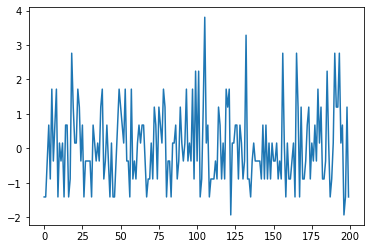

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
demand_data_encoded.head(200)['count'].plot(legend=False, ax=ax)
plt.show()


#### Register model

In [ ]:
az ml model create --name torch_autoencoder --version 1  --path ./models/autoencoder.json

### Isolation Forest 

In [26]:
import random
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
demand_data['hour'] = demand_data.starttime.dt.hour
demand_data = demand_data[['location','car_type', 'hour','count']]


ct = ColumnTransformer([("ohe", OneHotEncoder(),['car_type','location'])], remainder="passthrough")
ct.fit(demand_data)
X_train, X_test = train_test_split(demand_data,test_size=0.2)
# X_test['count'] = X_test['count'] 

clf = IsolationForest(contamination=0.04)
pipeline = Pipeline([("ct", ct), ("model", clf)])

pipeline.fit(X_train)
predictions = pipeline.predict(X_test)
print("len ", len(predictions), "sum", sum(predictions))
signature = infer_signature(X_train, pipeline.predict(X_train))
# mlflow.sklearn.log_model(pipeline, "isolation_forest", signature=signature)



len  541 sum 493


c:\Users\janguy\Anaconda3\envs\dlresearch\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


## Test local inference

In [28]:
pd.get_dummies(X_train[:5])

,hour,count,location_loc_0,location_loc_14,location_loc_19,location_loc_5,location_loc_8,car_type_comfort,car_type_x,car_type_xl
104,16,6,1,0,0,0,0,0,0,1
2043,18,2,0,0,0,1,0,1,0,0
841,19,3,0,1,0,0,0,1,0,0
1511,18,3,0,0,1,0,0,1,0,0
2531,19,3,0,0,0,0,1,0,1,0


In [10]:
import mlflow

model = mlflow.sklearn.load_model(model_uri="mlruns/0/6e98d315dbf142dc895bcd92d44dc5b9/artifacts/isolation_forest/")
demand_data.starttime = pd.to_datetime(demand_data.starttime)
demand_data['hour'] = demand_data.starttime.dt.hour
demand_data = demand_data[['location','car_type', 'hour','count']]
model.predict(demand_data.head())

array([1, 1, 1, 1, 1])

## Deployment 

In [ ]:
demand_data.head()

az ml model create --name isolation_forest --version 1 --type mlflow_model --path ./mlruns/0/6e98d315dbf142dc895bcd92d44dc5b9/artifacts/isolation_forest/ 

In [20]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data =  {
  "Inputs": {
    "data": [
      {
        "location": "loc_0",
        "car_type": "comfort",
        "hour": 15,
        "count": 2
      },
      {
        "location": "loc_0",
        "car_type": "comfort",
        "hour": 16,
        "count": 3
      }
    ]
  }
}
data =  {
  "Inputs": {
    "data": demand_data.head().to_dict()
  }
}

body = str.encode(json.dumps(data))

url = 'https://anomaly-detection.westus.inference.ml.azure.com/score'
api_key = 'x02RC8IWFJ5z7l6g3ya290vuyVxGRIjn' # Replace this with the API key for the web service

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key), 'azureml-model-deployment': 'deployment2' }

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

b'[1, 1, 1, 1, 1]'
